In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import math
from tqdm import trange
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307),(0.3081))])

train_data = datasets.MNIST("./data", train = True, download = True, transform = transform)
test_data = datasets.MNIST("./data", train = False, transform = transform)

train_loader = DataLoader(train_data, batch_size = 512, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 512, shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12622154.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 344902.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3191613.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4413931.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
print(train_data[0][0].size() , "=>" ,train_data[0][1])

torch.Size([1, 28, 28]) => 5


In [4]:
Xd, Yd = next(iter(DataLoader(train_data, batch_size = len(train_data))))
Xt, Yt = next(iter(DataLoader(test_data, batch_size = len(test_data))))

print(Xd[0].size() , "=>" ,Yd[0])

torch.Size([1, 28, 28]) => tensor(5)


In [5]:
torch.empty(1, 2, (2*2)).uniform_(-1, 1) # Initializing wt

tensor([[[-0.0925,  0.2184, -0.4117, -0.8701],
         [-0.5367,  0.7103,  0.6609, -0.1919]]])

In [6]:
torch.full((2, 1, 1, 1), 2) # Bits per weight

tensor([[[[2]]],


        [[[2]]]])

In [7]:
class Quant_Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()

    self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else tuple(kernel_size)
    scale = 1 / math.sqrt(in_channels * math.prod(self.kernel_size))
    self.wt = nn.Parameter(torch.empty(out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
    self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
    self.bits_per_wt = nn.Parameter(torch.full((out_channels, 1, 1, 1), 2.))

  def quant_bits(self):
    return self.bits_per_wt.relu().sum() * math.prod(self.wt.shape[1:])

  def quant_wt(self):
    A = 2**-self.e * self.wt
    B = -2**(self.bits_per_wt.relu()-1)
    C = 2**(self.bits_per_wt.relu()-1) -1

    return torch.minimum(torch.maximum(A, B), C)

  def forward(self, x):
    q_wt = self.quant_wt()
    wt = (q_wt.round() - q_wt).detach() + q_wt
    return F.conv2d(x, 2**self.e * wt)

In [8]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        Quant_Conv2d(1, 32, 5),
        nn.ReLU(),
        Quant_Conv2d(32,32,5),
        nn.ReLU(),
        nn.BatchNorm2d(32, affine = False, track_running_stats = False),
        nn.MaxPool2d(2),
        Quant_Conv2d(32, 64, 3), nn.ReLU(),
        Quant_Conv2d(64, 64, 3), nn.ReLU(),
        nn.BatchNorm2d(64, affine = False, track_running_stats = False),
        nn.MaxPool2d(2)
    )
    self.final_layer = nn.Linear(576, 10) # 64x3x3 = 576

  def forward(self, x):
    x = self.layers(x)
    x = torch.flatten(x, 1)
    x = self.final_layer(x)
    return x

  def quant_bits(self):
    return sum(layer.quant_bits() for layer in self.layers if isinstance(layer, Quant_Conv2d))

In [9]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())
wt_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
def train():
  model.train()
  optimizer.zero_grad()
  x = torch.randint(0, Xd.shape[0], (512,))
  y = model(Xd[x].to(device))
  loss = F.cross_entropy(y, Yd[x].to(device))

  Q = model.quant_bits() / wt_count # Q = Average Bit Depth
  compression_factor = 0.05
  loss = loss + compression_factor*Q

  loss.backward()
  optimizer.step()
  return loss.item(), Q.item()

In [11]:
def test_accuracy():
  model.eval()
  with torch.no_grad():
    outputs = model(Xt.to(device))
    pred = outputs.argmax(dim = 1)
    accuracy = (pred == Yt.to(device)).float().mean().item() * 100
    return accuracy

In [16]:
accuracy = 0.0
accuracies, bytes_used = [], []
for epoch in (t := trange(4000)):
  loss, Q = train()
  model_bytes = Q / 8 * wt_count
  if epoch % 10 == 9:
    accuracy = test_accuracy()
  accuracies.append(accuracy)
  bytes_used.append(model_bytes)
  t.set_postfix(loss = loss, accuracy = accuracy, model_bytes = model_bytes)

100%|██████████| 4000/4000 [02:04<00:00, 32.25it/s, accuracy=97.6, loss=0.125, model_bytes=1.58e+4]


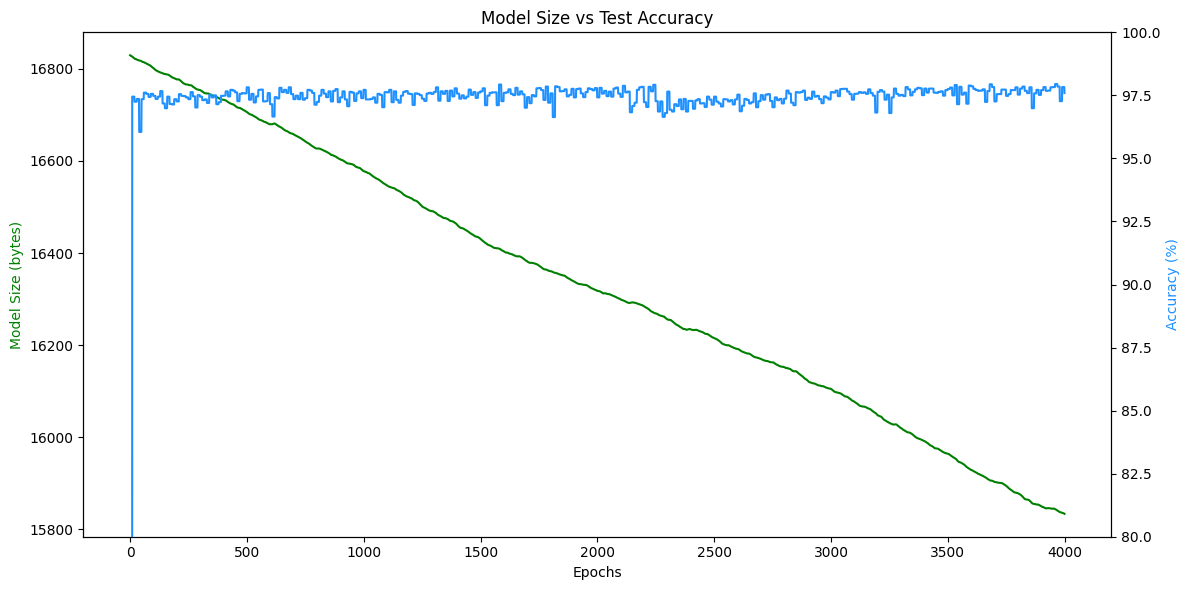

In [21]:
figure, axis = plt.subplots(figsize = (12, 6))

axis.set_xlabel("Epochs")

axis.set_ylabel("Model Size (bytes)", color="green")
axis.plot(bytes_used, color="green")
axis.tick_params(axis='y')

axis2 = axis.twinx()
axis2.set_ylabel("Accuracy (%)", color="dodgerblue")
axis2.plot(accuracies, color = "dodgerblue")
axis2.tick_params(axis='y')

axis2.set_ylim(80, 100)
plt.title('Model Size vs Test Accuracy')
figure.tight_layout()
plt.show()